# Nonce distribution analysis

## Introduction

This notebook explores how the distribution of nonces is impacted by the number of workers between which hashing is divided.
For example, consider miners employing the nonce search strategy of starting at 0 and iterating upwards, and imagine that it takes about 10,000 hashes to mine a block on average.
+ Scenario 1: If these 10,000 hashes are being carried out by a single worker, then we expect to see nonces scattered throughout that range (e.g. nonce values around 7000, 10000, and 20000 would not be surprising)
+ Scenario 2: If these 10,000 hashes are divided between 1,000 workers in parallel, then one of them is statistically likely to find a block by the time that they are all 10 or 20 hashes in. (so a nonce value of 7000 would be extraordinarily unlikely, because that would mean that no block was found in the first 7,000*(1,000 workers) = 7,000,000 hashes!

Here, we explore the relationship between worker count and nonce distribution. For convenience, this notebook focuses on miners employing a nonce search strategy of incrementing upwards from 0, which is the dominant strategy in many PoW cryptocurrencies.
The same logic and analysis can be applied to other observed nonce search strategies such as incrementing upwards from the halfway point of the nonce range, or decrementing from the top of the nonce range.
This approach cannot be applied to extract any information about miners who select a random starting nonce for each block.
As discused at the end of [Utter “Noncesense” — a statistical study of nonce value distribution on the Monero blockchain](https://medium.com/hackernoon/utter-noncesense-a-statistical-study-of-nonce-value-distribution-on-the-monero-blockchain-f13f673a0a0d), I recommend that PoW miners adopt a strategy of selection of an initial starting nonce (uniformly random over the nonce range) and incrementing from there. This suffices to thoroughly styme statistical analysis, while only requiring one call to the random() function before the first hash.

## Model description

The simulator below defines a `Worker` object (representing a single mining worker) and a `Network` object (representing the state and history of the blockchain). **It should be emphasized that this model was designed for easy physical interpretability rather than efficiency.** This approach is meant to be intuitive, so some optimizations were skipped (for example, if 1 million simulated workers have the same search strategy and hashrate, the below approach of instantiating and storing 1M worker objects is silly - we could just iterate over one object 1M times)

For each `Worker`, the following parameters can be specified:
+ `hashes_per_second` (default: `100`)
+ `search_strategy`, can be `increment_from_0` (default), `increment_from_halfway`, `decrement_from_top`, and `uniform`. These are the main strategies observed in Firo and Monero
+ `nonce_range` (default: `2**32`)
+ `workerID` (default: randomly generated)
The worker methods such as `single_hash`, `hash_n_times`, and `hash_n_seconds` return True if a block is found (else: false) and update the worker object's nonce according to its search strategy

The `Network` has a few fields that mimic consensus state (`height` and `fractional_difficulty`) and stores history,
such as `block_height_list` for `block_nonce_list` blocks previously mined by simulated workers. There are 3 steps to begin mining

[1] instantiate the network:

`N = Network(fractional_difficulty = 0.9995)`

[2] initialize a set of miner workers:

`N.initialize_n_workers(number_of_workers = 10, worker_hashes_per_second = 5)`

[3] mine some blocks:

`N.mine_n_blocks(number_of_blocks = 2000, verbose = False)`

To see the resulting state of the network, use its print method, which takes in a verbosity level - `N.print(2)` will show heights and nonces.

To jump to the results, check out the plots at the bottom of this notebook.

## Contact

Isthmus / PoW-simulator@mitchellpkt.com

March 2020


## Import libraries

In [1]:
import numpy as np
import isthmuslib as isli
import matplotlib.pyplot as plt
import random as random

## Mimic checking if a hash satisfies difficulty

In [3]:
def hash_attempt_boolean(fractional_difficulty):
    random_num = random.random()
    if random_num >= fractional_difficulty:
        return True
    else:
        return False

## Define `Worker` and `Network` classes

In [16]:
def get_initial_nonce(search_strategy, nonce_range):
    # Pick initial nonce
    if search_strategy == 'increment_from_0':
        return 0
    elif search_strategy == 'increment_from_halfway':
        return int(np.floor(nonce_range / 2))
    elif search_strategy == 'decrement_from_top':
        return int(nonce_range)
    elif search_strategy == 'uniform':
        return int(np.floor(random.random()*nonce_range))


class Worker:

    def __init__(self, hashes_per_second=100, search_strategy = 'increment_from_0', nonce_range = 2**32, workerID = None):
        self.hashes_per_second = hashes_per_second
        self.found_block_yet = False
        self.search_strategy = search_strategy
        self.nonce_range = nonce_range
        self.nonce = get_initial_nonce(search_strategy, nonce_range)
        if workerID is None:
            self.workerID = int(np.floor(random.random()*1000000))
        else:
            self.workerID = workerID

    def reset(self):
        self.found_block_yet = False
        self.nonce = get_initial_nonce(self.search_strategy, self.nonce_range)

        # Pick reset nonce
        if self.search_strategy == 'increment_from_0':
            self.nonce = 0
        elif self.search_strategy == 'increment_from_halfway':
            self.nonce = np.floor(self.nonce_range / 2)
        elif self.search_strategy == 'decrement_from_top':
            self.nonce = np.floor(self.nonce_range)
        elif self.search_strategy == 'uniform':
            self.nonce = int(np.floor(random.random()*self.nonce_range))

    def single_hash(self, fractional_difficulty, verbose = False):
        
        # Make an attempt
        attempt_result = hash_attempt_boolean(fractional_difficulty)
        if attempt_result:
            self.found_block_yet = True
            
        # Update the nonce
        if (self.search_strategy == 'increment_from_0') or (self.search_strategy == 'increment_from_halfway'):
            self.nonce += 1
        elif self.search_strategy == 'decrement_from_top':
            self.nonce -= 1
        elif self.search_strategy == 'uniform':
            self.nonce = int(np.floor(random.random()*self.nonce_range))
            # Note that it would be fine to select a random starting nonce once per block, then increment there
        else:
            return NameError('Search strategy not recognized')
            
        return attempt_result
    
    def hash_n_times(self, number_of_hashes, fractional_difficulty, verbose = False):
        iteration = 0
        while (self.found_block_yet == False)& (iteration <= number_of_hashes):
            self.single_hash(fractional_difficulty)
            if verbose:
                print('--------------')
                print('Nonce: ' + str (self.nonce))
                print('Step iteration: ' + str(iteration) + ' of ' + str(number_of_hashes))
                print('Successful? ' + str(self.found_block_yet))
            iteration += 1
        return self.found_block_yet
            
    def hash_n_seconds(self, number_of_seconds, fractional_difficulty, verbose = False):
        number_of_hashes = number_of_seconds * self.hashes_per_second
        self.hash_n_times(number_of_hashes, fractional_difficulty, verbose = verbose)
        return self.found_block_yet

    def print(self):
        print('---------------')
        print('Worker hashrate: ' + str(self.hashes_per_second) + ' H/s')
        print('Search strategy: '+ self.search_strategy)
        print('Nonce range: ' + str(self.nonce_range))
        print('Current nonce: ' + str(self.nonce))
        print('Found block yet: ' + str(self.found_block_yet))

class Network:
    def __init__(self, height=0, fractional_difficulty=0.99):
        self.height = height
        self.fractional_difficulty = fractional_difficulty
        self.block_height_list = list()
        self.block_nonce_list = list()
        self.block_producer_list = list()
        self.worker_objects = list()

    def initialize_n_workers(self, number_of_workers=100, worker_hashes_per_second=10, search_strategy = 'increment_from_0', nonce_range = 2**32):
        for n in range(number_of_workers):
            self.worker_objects.append(Worker(hashes_per_second=worker_hashes_per_second, search_strategy = search_strategy, nonce_range = nonce_range))

    def mine_1_block(self, timestep_seconds = 1, verbose = False):
        found_block = False
        nth_step = 0
        while not found_block:
            if verbose:
                print('$$$$$$$$$$ nth_step #: ' + str(nth_step))
            for count, worker_object in enumerate(self.worker_objects):
                if nth_step == 0:
                    worker_object.reset()
                result = worker_object.hash_n_seconds(timestep_seconds, self.fractional_difficulty, verbose = verbose)
                # Do I have to put the object back??
                self.worker_objects[count] = worker_object
                if verbose:
                    print('**********************')
                    print('Count: ' + str(count) + ' // workerID: ' + str(worker_object.workerID))
                    print("Result: " + str(result))
                if result:
                    found_block = True
                    self.block_height_list.append(self.height)
                    self.block_nonce_list.append(worker_object.nonce)
                    self.block_producer_list.append(worker_object.workerID)
                    self.height += 1
                    worker_object.reset()
                    break
                else:
                    nth_step += 1

    def mine_n_blocks(self, number_of_blocks, timestep_seconds = 1, verbose = False):
        for _ in range(number_of_blocks):
            self.mine_1_block(timestep_seconds = timestep_seconds, verbose = verbose)

    def print(self, level=1):
        print("--------")
        print("Height: " + str(self.height))
        print("Fractional difficulty: "  + str(self.fractional_difficulty))
        print("Number of blocks: " + str(len(self.block_height_list)))
        print("Number of workers: " + str(len(self.worker_objects)))
        if level > 1:
            for h in range(len(self.block_height_list)):
                print('Height: ' + str(self.block_height_list[h]) + ' | Nonce: ' +  str(self.block_nonce_list[h]) + ' | Worker: ' +  str(self.block_producer_list[h]))

## Example simulations

### Model parameters
Set parameters for some simulations

In [6]:
fractional_difficulty = 0.99999 # Lower this if taking too long to run
number_of_blocks = 20000 # Sample size
individual_plots = False # Show intermediate plots?

### Run simulations
First, simulate mining with only a few workers

In [7]:
number_of_workers_small = 10
N = Network(fractional_difficulty = fractional_difficulty)
N.initialize_n_workers(number_of_workers = number_of_workers_small,worker_hashes_per_second=5)
N.mine_n_blocks(number_of_blocks=number_of_blocks, verbose=False)
if individual_plots:
    isli.scatter(N.block_height_list, N.block_nonce_list, xlabel='height', ylabel='nonce', markersize=50, title = "Nonce distribution with " + str(number_of_workers_small) + ' workers')
    isli.hist(N.block_nonce_list, xlabel='nonce', ylabel='frequency', title = "Nonce distribution with " + str(number_of_workers_small) + ' workers');

And now with more workers

In [ ]:
number_of_workers_medium = 10_000
M = Network(fractional_difficulty = fractional_difficulty)
M.initialize_n_workers(number_of_workers = number_of_workers_medium,worker_hashes_per_second=5)
M.mine_n_blocks(number_of_blocks=number_of_blocks, verbose=False)
if individual_plots:
        isli.scatter(M.block_height_list, M.block_nonce_list, xlabel='height', ylabel='nonce', markersize=50, title = "Nonce distribution with " + str(number_of_workers_medium) + ' workers')
        isli.hist(M.block_nonce_list, xlabel='nonce', ylabel='frequency', title = "Nonce distribution with " + str(number_of_workers_medium) + ' workers');

In [ ]:
number_of_workers_large = 1_000_000
L = Network(fractional_difficulty = fractional_difficulty)
L.initialize_n_workers(number_of_workers = number_of_workers_large ,worker_hashes_per_second=5)
L.mine_n_blocks(number_of_blocks=number_of_blocks, verbose=False)
if individual_plots:
    isli.scatter(L.block_height_list, L.block_nonce_list, xlabel='height', ylabel='nonce', markersize=50, title = "Nonce distribution with " + str(number_of_workers_large) + ' workers')
    isli.hist(L.block_nonce_list, xlabel='nonce', ylabel='frequency', title = "Nonce distribution with " + str(number_of_workers_large) + ' workers');

### Visualize simulation results
View the results on both linear and log y-axes. (Note that first cell plots raw block counts, whereas the second cell normalizes the y-axis to density)

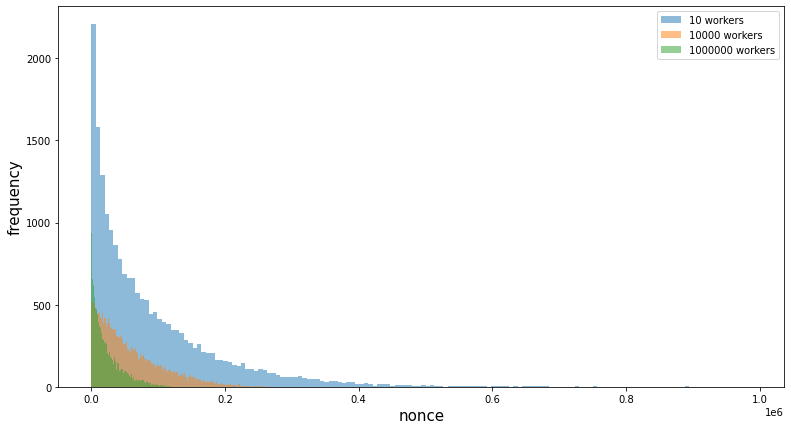

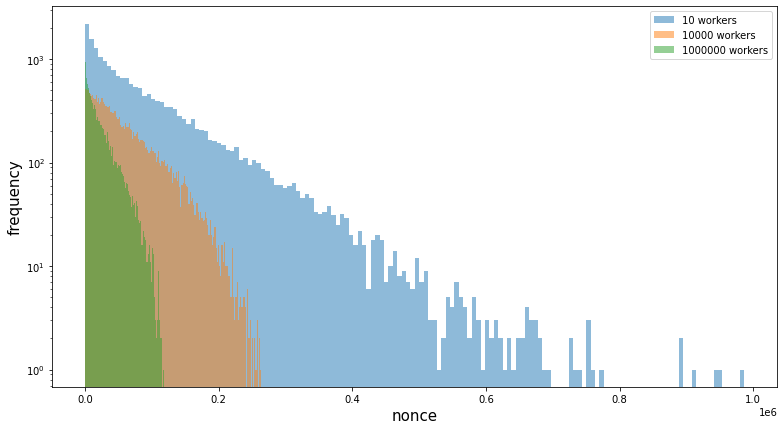

In [13]:
dataDict = {
    str(number_of_workers_small) + " workers":N.block_nonce_list,
    str(number_of_workers_medium) + " workers":M.block_nonce_list,
    str(number_of_workers_large) + " workers":L.block_nonce_list
    }
legend = (str(number_of_workers_small) + " workers", str(number_of_workers_medium) + " workers", str(number_of_workers_large) + " workers")
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5)
plt.legend(legend)
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5, yscale='log')
plt.legend(legend);

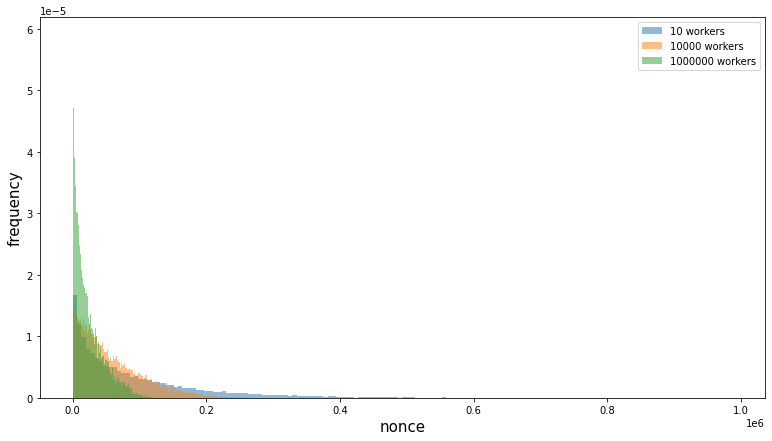

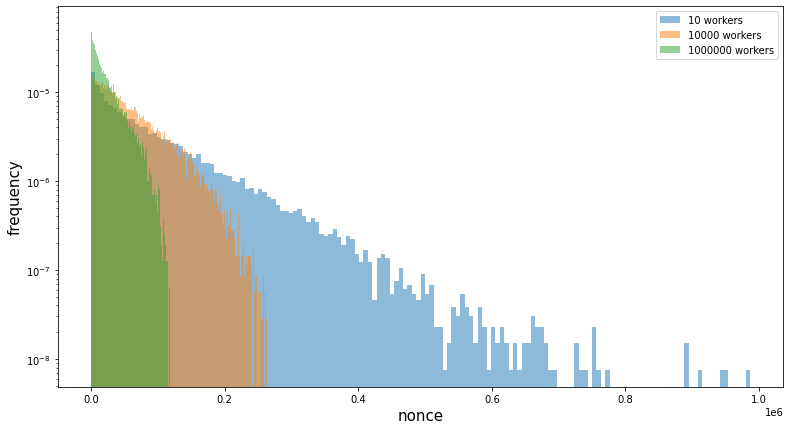

In [14]:
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5, density=True)
plt.legend(legend)
isli.hist(dataDict, xlabel = "nonce", ylabel = "frequency", alpha=0.5, yscale='log', density=True)
plt.legend(legend)